# Disclaimer: I know pretty much nothing about soccer, and even less about the Premier League.
### (please don't come after me, hooligans)

In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline
torch.set_default_dtype(torch.float64)
torch.manual_seed(0)  # <-- What even is the purpose of this?

## Hey everyone, did you catch the game yesterday? Arsenal versus Cardiff United! What an intense game.
### In fact, it was so intense that the Football Association deployed a first-of-its-kind, top-of-the-line, fresh-off-the-shelf fan feedback system called the Group Optimism Assessment and Loudness Indicator for Enthusiasm (GOALIE).
### The GOALIE is a very advanced and complicated technology that combines everything from the volume inside a stadium to the aggressiveness of Premier League-related social media posts in order to assess how much the fans were enjoying the game.

### The GOALIE's output is formulated once per minute during the match and is only decipherable by the FA's leading scientists. It might look, for example, something like this:

Text(0, 0.5, 'Crowd enthusiasm')

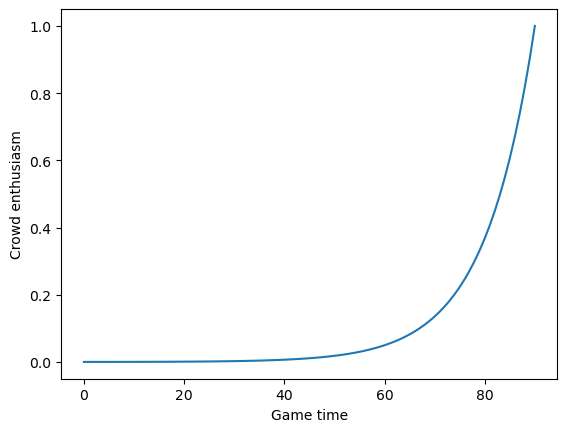

In [2]:
game_time = torch.arange(0, 91, 1)
enthusiasm = torch.exp(game_time/10)/8103  # Nothing to see here
plt.plot(game_time.numpy(), enthusiasm.numpy())
plt.xlabel("Game time")
plt.ylabel("Crowd enthusiasm")

### As I was saying, the match was going spiffingly...
# Until distaster struck!
### A mob of die-hard Cardiff United fans got it into their heads that GOALIE was biased and would issue higher ratings whenever Arsenal scored. They put on their ninja outfits and stormed the secure facility where GOALIE's outputs were being kept. 
### We all thought that was the end of things, but fortunately, a portion of the data were able to be recovered because they had been stored on *fireproof* magnetic tape (not that trash you'd get in a compact cassette).

### These are the remaining data:

I'm so sorry. We could only save the records of the following minutes of the match:
 tensor([ 1, 10, 20, 22, 33, 34, 36, 38, 44, 49, 54, 59, 69, 73, 76, 77, 81, 83,
        85, 87])


Text(0, 0.5, 'Crowd enthusiasm')

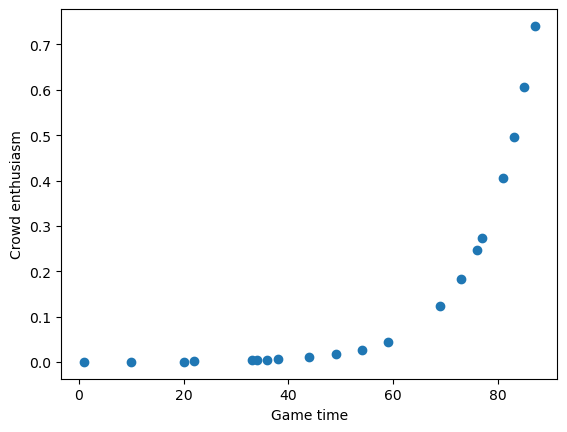

In [3]:
num_indices_to_keep = 20
torch.manual_seed(0)
indices_to_keep = torch.randperm(len(game_time))[:num_indices_to_keep].sort()[0]
reduced_game_time = game_time[indices_to_keep]
reduced_enthusiasms = enthusiasm[indices_to_keep]  # "Reduced" as in "subset", not as in "less enthusiastic", lol
print("I'm so sorry. We could only save the records of the following minutes of the match:\n", reduced_game_time)
assert len(reduced_game_time) == len(reduced_enthusiasms)  # Just in case
plt.scatter(reduced_game_time.numpy(), reduced_enthusiasms.numpy())
plt.xlabel("Game time")
plt.ylabel("Crowd enthusiasm")

### What could the missing data possibly have been?
### Well, the FA has heard tell about our skill with machine learning. They have tasked us with reconstucting GOALIE's output for this match. 
### Not only that, we need to build an explainable model so that we can do this more easily if this happens again in the future (and you know it will).
### In exchange, they will give each of us a flat +500 point bonus to our Fantasy Premier League teams, each season, in perpetuity.

## Let's make a model to predict crowd enthusiasm given the minute of the game.

In [4]:
scaler = StandardScaler()
reduced_game_time = torch.from_numpy(scaler.fit_transform(reduced_game_time.reshape(-1, 1)))  # Scale the input data
reduced_enthusiasms = reduced_enthusiasms.unsqueeze(1)  # Ensure the tensor dimensions are up to PyTorch's exacting standards
training_dataset = TensorDataset(reduced_game_time, reduced_enthusiasms) # Create an object to represent our training dataset...
train_loader = DataLoader(training_dataset, shuffle=True, num_workers=0)  # ...and a dataloader to handle it

### Remember the Universal Approximation Theorem: Neural networks are functions, and for every function, there exists some neural network that can approximate it to within arbitrary accuracy requirements.
### Even though we don't know what it was, there was *some* functional mapping between time and Enthusiasm, F:t→E. Our goal is to train our neural network so that it *becomes* F.

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, batch_size=1):
        super().__init__()
        
        # Nothing fancy here.
        self.fc1 = nn.Linear(batch_size, 100)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(100, 1)

    def forward(self, x):
        '''Once trained, this function is the mapping F we're seeking.'''
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.output(x)
        return x

In [6]:
def train_model(model, train_loader, loss_fn, num_epochs=200):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()  # Put the model in training mode
    for epoch in tqdm.trange(num_epochs, desc="Training model. Epoch"):
        for step_num, datum in enumerate(train_loader):  # Objects in a dataloader must be accessed this way
            inputs, targets = datum  # Inputs = time, targets = enthusiasm
            optimizer.zero_grad()  # Reset the gradients so they don't accumulate over successive backpropagations
            outputs = model(inputs)  # Good ol' forward pass
            loss = loss_fn(outputs, targets)  # Calculate the loss between predicted data and ground truth
            loss.backward()  # Use loss to update weights
            optimizer.step()  # Update the stochastic gradient descent optimizer
            
            
def validate_model(model, valid_loader, scatter_plot=False):
    model.eval()  # Put the model in evaluation mode
    with torch.no_grad():  # Get the output of the model without calculating gradients, i.e. do inference
        for i, valid_datum in enumerate(valid_loader):
            valid_inputs, valid_targets = valid_datum
            predictions = model(valid_inputs)
    valid_inputs = torch.from_numpy(scaler.inverse_transform(valid_inputs))  # Unscale inputs for comparison
    valid_targets = valid_targets.unsqueeze(1)  # Satisfy PyTorch's thirst for dimensions
    valid_loss_fn = nn.MSELoss()  # This seems like a good loss function to me
    valid_loss = torch.sqrt(valid_loss_fn(valid_targets, predictions))  # Convert MSE to RMSE for units' sake
    if scatter_plot:
        plt.scatter(valid_inputs.numpy(), valid_targets.to('cpu').numpy(), label="Actual")
        plt.scatter(valid_inputs.numpy(), predictions.to('cpu').numpy(), label="Predicted", color="orange")
    else:
        plt.plot(valid_inputs.numpy(), valid_targets.to('cpu').numpy(), label="Actual")
        plt.plot(valid_inputs.numpy(), predictions.to('cpu').numpy(), label="Predicted", color="orange")
    plt.legend()
    plt.xlabel("Game time")
    plt.ylabel("Crowd enthusiasm")
    plt.title(f"Loss: {valid_loss.item()}")

In [7]:
torch.manual_seed(0)  # We really have to set this up every time? I hope I didn't miss one of these
Predictor = NeuralNetwork()
loss_fn = nn.MSELoss()  # Loss function for training. I don't really feel motivation to implement test loss
train_model(Predictor, train_loader, loss_fn)

Training model. Epoch: 100%|██████████| 200/200 [00:05<00:00, 36.20it/s]


### Let's take a look at the model's performance on its own training data.

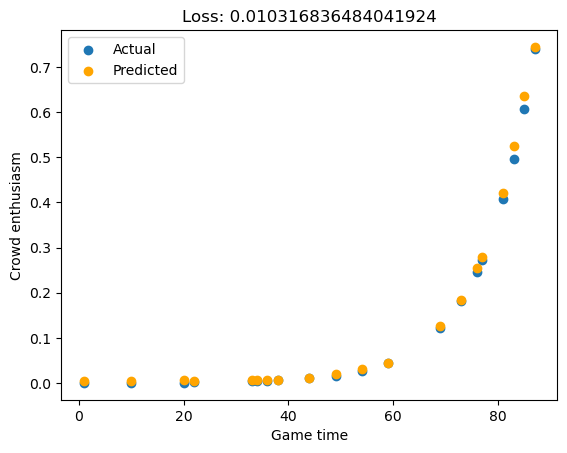

In [8]:
test_dataset = TensorDataset(reduced_game_time, reduced_enthusiasms.squeeze(1))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)
validate_model(Predictor, test_loader, scatter_plot=True)

### In a dream, the true GOALIE output is briefly revealed to us for validation purposes.

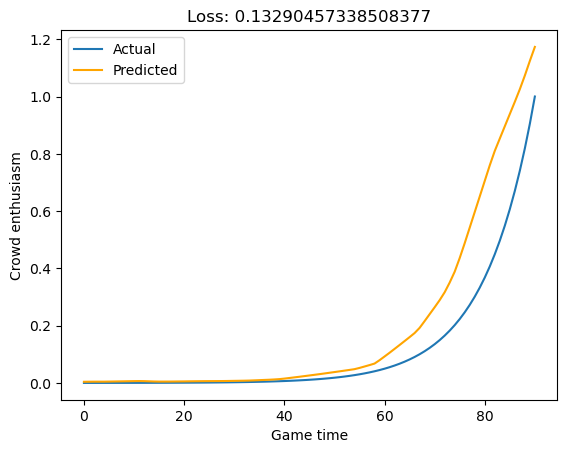

In [9]:
# The input to GOALIE is know to us: the numbers 0 through 90
scaled_game_time = torch.from_numpy(scaler.fit_transform(game_time.reshape(-1, 1)))  # Scale validation input data
valid_dataset = TensorDataset(scaled_game_time, enthusiasm)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False, num_workers=0)
validate_model(Predictor, valid_loader)

### Not bad, but the elemet-wise loss drastically increases with the gradient of the function.

### Now, does the model generalize? It turns out last night's match went into extra time (that explains why the enthusiasm was so high at the end there). Thankfully, we have the entirety of those GOALIE outputs, probably because the hooligan ninjas didn't realize league games even went into extra time.

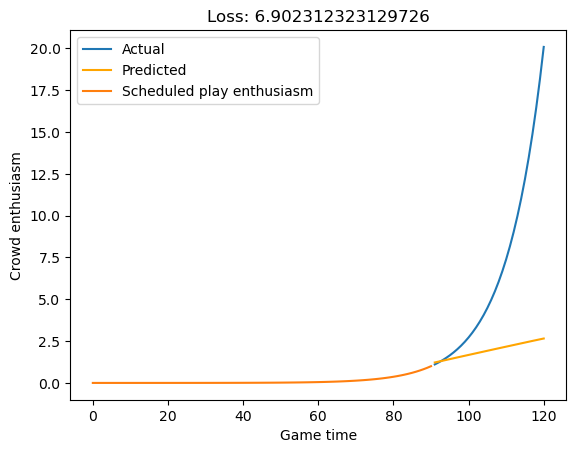

In [10]:
extra_time = torch.arange(91, 121, 1)  # The 30 minutes of extra time
extra_enthusiasm = torch.exp(extra_time/10)/8103  # GOALIE's outputs during that time
extra_time = torch.from_numpy(scaler.transform(extra_time.reshape(-1, 1)))  # Scale the inputs

valid_dataset = TensorDataset(extra_time, extra_enthusiasm)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False, num_workers=0)
validate_model(Predictor, valid_loader)
plt.plot(game_time.numpy(), enthusiasm.numpy(), label="Scheduled play enthusiasm")
plt.legend()

## The model generalizes very poorly. That's probably fine, since I'm told the GOALIE score is not supposed to exceed 1 anyway. The system must have been overwhelmed by the sheer amount of fan support.
### Notice how the slope at the end of regular time is approximately preserved.

## "But we have information that the model doesn't -- it looks to me like the governing law of GOALIE is just the Tsiolkovsky Rocket Equation!"
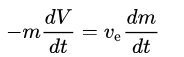
### Yeah, that's because Arsenal was absolutely TAKING OFF with the game!!!!
### That's a good point, though. If you can guess the form of the generator of the mapping F, you can apply it as a physical constraint via the loss function.
### In fact, you can (and with enough compute, you arguably *should*) add terms that ought to equal zero to your loss function, since the goal of training is to minimize loss.
### Remember Langrange multipliers from classical mechanics? Neither do I. But it's that.
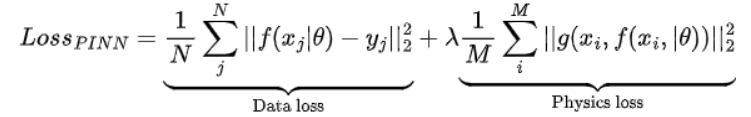
<p style="text-align: center;">Formulation credit: Theo Wolf, https://medium.com/@theo.wolf</p>

In [11]:
class PINN(NeuralNetwork):
    def __init__(self):
        super().__init__()
        
    def grad(self, outputs, inputs):
        '''A neural network is a differentiable function, so differentiate it!'''
        return torch.autograd.grad(
            outputs, 
            inputs, 
            grad_outputs=torch.ones_like(outputs), 
            create_graph=True)
    
    def physics_loss(model: nn.Module):
        """The physics loss of the model"""
        # make collocation points
        clps = torch.linspace(0, 90, steps=100,).view(-1,1).requires_grad_(True)
        # run the collocation points through the network
        samples = model(clps)
        # get the gradient
        dNNdt = model.grad(samples, clps)[0]
        # compute the loss between the predictions at collocation points and the physical equation
        growth_rate = 1/10
        ode = dNNdt - growth_rate * samples

        return torch.mean(ode**2)
    
    
def train_physics_model(model, train_loader, data_loss_fn, num_epochs=200):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in tqdm.trange(num_epochs, desc="Training model. Epoch"):
        for step_num, datum in enumerate(train_loader):
            inputs, targets = datum
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = model.physics_loss() + data_loss_fn(outputs, targets)  # Lambda is 1 here for simplicity,
            # though in principle it's a hyperparameter that you ought to optimize
            loss.backward()
            optimizer.step()   

In [12]:
torch.manual_seed(0)
PhysicsPredictor = PINN()
mseloss = nn.MSELoss()
train_physics_model(PhysicsPredictor, train_loader, data_loss_fn=mseloss)

Training model. Epoch: 100%|██████████| 200/200 [00:13<00:00, 14.59it/s]


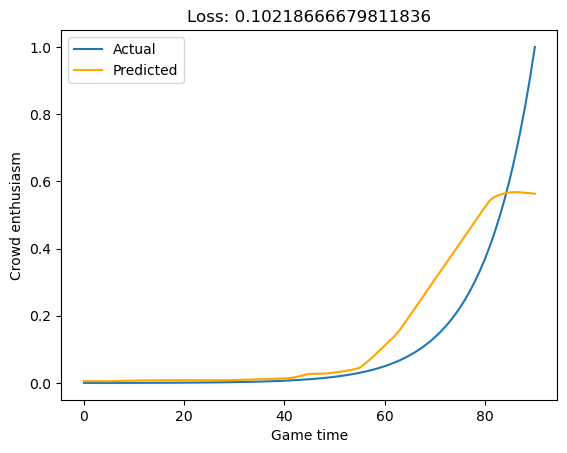

In [13]:
valid_dataset = TensorDataset(scaled_game_time, enthusiasm)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False, num_workers=0)
validate_model(PhysicsPredictor, valid_loader)

## The PINN is better in some ways but worse in others.
### Maybe we can improve performance in the region of large gradient by adding more collocation points specific to that region.

In [14]:
class PINN(NeuralNetwork):
    def __init__(self):
        super().__init__()
        
    def grad(self, outputs, inputs):
        return torch.autograd.grad(
            outputs, 
            inputs, 
            grad_outputs=torch.ones_like(outputs), 
            create_graph=True)
    
    def physics_loss(model: nn.Module):
        clps = torch.linspace(0, 90, steps=100,).view(-1,1).requires_grad_(True)
        extreme_clps = torch.linspace(70, 90, steps=100,).view(-1,1).requires_grad_(True)  # More CLPs!
        clps = torch.cat((clps, extreme_clps), 0)
        samples = model(clps)
        dNNdt = model.grad(samples, clps)[0]
        growth_rate = 1/10
        ode = dNNdt - growth_rate * samples

        return torch.mean(ode**2)
    
    
def train_physics_model(model, train_loader, data_loss_fn, num_epochs=200):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in tqdm.trange(num_epochs, desc="Training model. Epoch"):
        for step_num, datum in enumerate(train_loader):
            inputs, targets = datum
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = model.physics_loss() + data_loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()   

In [15]:
torch.manual_seed(0)
PhysicsPredictor = PINN()
mseloss = nn.MSELoss()
train_physics_model(PhysicsPredictor, train_loader, data_loss_fn=mseloss)

Training model. Epoch: 100%|██████████| 200/200 [00:16<00:00, 12.00it/s]


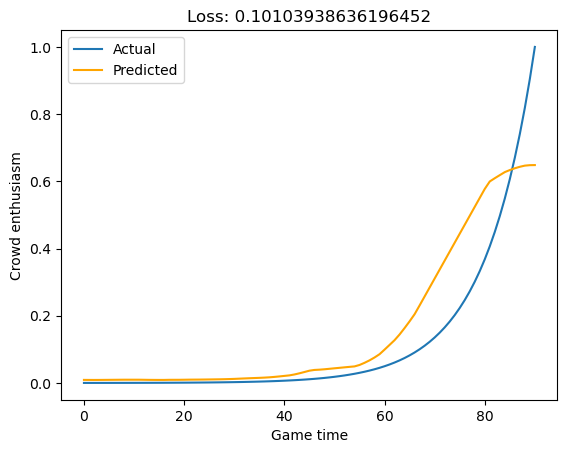

In [16]:
valid_dataset = TensorDataset(scaled_game_time, enthusiasm)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False, num_workers=0)
validate_model(PhysicsPredictor, valid_loader)

In [17]:
class PINN(NeuralNetwork):
    def __init__(self):
        super().__init__()
        
    def grad(self, outputs, inputs):
        return torch.autograd.grad(
            outputs, 
            inputs, 
            grad_outputs=torch.ones_like(outputs), 
            create_graph=True)
    
    def physics_loss(model: nn.Module):
        clps = torch.linspace(0, 90, steps=100,).view(-1,1).requires_grad_(True)
        extreme_clps = torch.linspace(70, 90, steps=1000,).view(-1,1).requires_grad_(True)  # EVEN MORE CLPs!!!!
        clps = torch.cat((clps, extreme_clps), 0)
        samples = model(clps)
        dNNdt = model.grad(samples, clps)[0]
        growth_rate = 1/10
        ode = dNNdt - growth_rate * samples

        return torch.mean(ode**2)
    
    
def train_physics_model(model, train_loader, data_loss_fn, num_epochs=200):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in tqdm.trange(num_epochs, desc="Training model. Epoch"):
        for step_num, datum in enumerate(train_loader):
            inputs, targets = datum
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = model.physics_loss() + data_loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()   

In [18]:
torch.manual_seed(0)
PhysicsPredictor = PINN()
mseloss = nn.MSELoss()
train_physics_model(PhysicsPredictor, train_loader, data_loss_fn=mseloss)

Training model. Epoch: 100%|██████████| 200/200 [00:28<00:00,  7.11it/s]


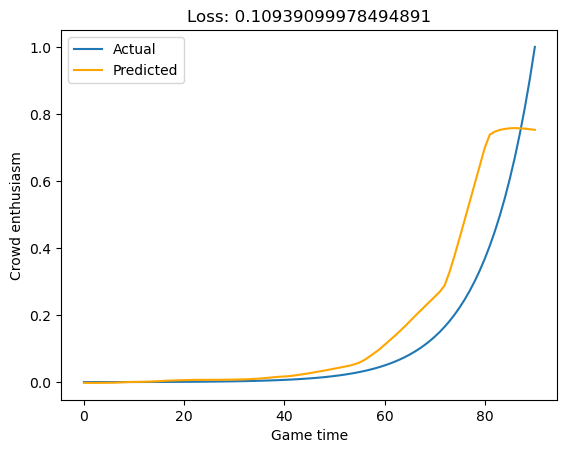

In [19]:
valid_dataset = TensorDataset(scaled_game_time, enthusiasm)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False, num_workers=0)
validate_model(PhysicsPredictor, valid_loader)

## Excellent! By engineering collocation points and the loss function in general, we can enforce physical constraints and get the reconstruction of GOALIE to look more like we'd expect.

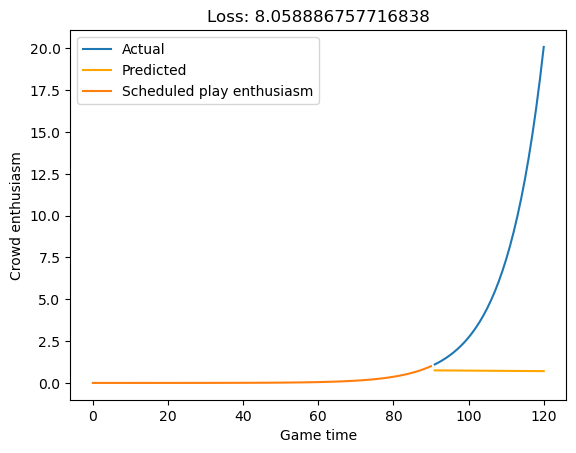

In [20]:
valid_dataset = TensorDataset(extra_time, extra_enthusiasm)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False, num_workers=0)
validate_model(PhysicsPredictor, valid_loader)
plt.plot(game_time.numpy(), enthusiasm.numpy(), label="Scheduled play enthusiasm")
plt.legend()

## It, uh, still doesn't generalize, though.
### this is almost certainly because we massively overfit the model to obtain a good reconstruction of regular time, and also because we did no hyperparameter optimization.

# Part 2: Equation Discovery
### What if we know the form of the governing laws, but have no idea about their coefficients?
### That's easy! Just make those coefficients in the loss function trainable parameters.

In [21]:
class DiscovererPINN(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.growth_rate = nn.Parameter(data=torch.tensor([0.1]))  # Look, a new parameter!
        
    def grad(self, outputs, inputs):
        return torch.autograd.grad(
            outputs, 
            inputs, 
            grad_outputs=torch.ones_like(outputs), 
            create_graph=True)
    
    def physics_loss(model: nn.Module):
        # make collocation points
        clps = torch.linspace(0, 90, steps=100,).view(-1,1).requires_grad_(True)
        extreme_clps = torch.linspace(70, 90, steps=1000,).view(-1,1).requires_grad_(True)
        clps = torch.cat((clps, extreme_clps), 0)
        samples = model(clps)
        dNNdt = model.grad(samples, clps)[0]
        ode = dNNdt - model.growth_rate * samples

        return torch.mean(ode**2)

In [22]:
torch.manual_seed(0)
PhysicsPredictor = DiscovererPINN()
mseloss = nn.MSELoss()
train_physics_model(PhysicsPredictor, train_loader, data_loss_fn=mseloss)

Training model. Epoch: 100%|██████████| 200/200 [00:30<00:00,  6.57it/s]


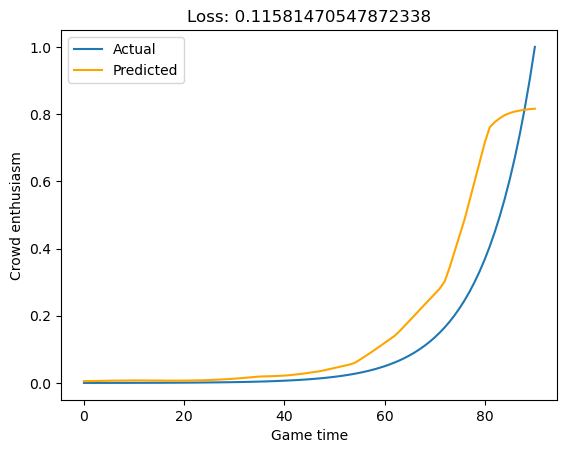

In [23]:
valid_dataset = TensorDataset(scaled_game_time, enthusiasm)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset), shuffle=False, num_workers=0)
validate_model(PhysicsPredictor, valid_loader)

In [24]:
for name, param in PhysicsPredictor.named_parameters():
    if param.requires_grad:
        print(name, param.data)

growth_rate tensor([0.0095])
fc1.weight tensor([[ 0.9436],
        [ 0.3923],
        [-0.0238],
        [ 0.8380],
        [ 0.2751],
        [ 0.5756],
        [-0.5857],
        [-0.2814],
        [ 0.1540],
        [-0.3846],
        [-0.0338],
        [-0.6111],
        [-0.1199],
        [ 0.2594],
        [-0.1065],
        [-0.1184],
        [-0.1288],
        [-0.5140],
        [ 0.3280],
        [ 0.5579],
        [-0.5241],
        [ 0.3503],
        [-0.7356],
        [ 0.0313],
        [-0.5205],
        [ 0.1040],
        [ 0.1836],
        [ 0.3538],
        [ 0.5090],
        [-0.4702],
        [ 0.6061],
        [ 0.2701],
        [-0.5301],
        [-0.6426],
        [-0.0370],
        [ 0.8104],
        [ 0.1408],
        [-0.0757],
        [ 0.5921],
        [-0.2333],
        [-0.4255],
        [-0.8405],
        [ 0.5065],
        [-0.2790],
        [ 0.0886],
        [-0.0864],
        [ 0.7168],
        [-0.8819],
        [ 0.9588],
        [ 0.7537],
        [ 

# So were we able to approximate GOALIE?
### Let's just say our model isn't a keeper.
I guess we can say goodbye to those free fantasy points.
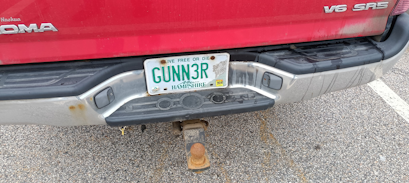